In [15]:
import os
import string
import sys
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from xgboost import XGBRegressor
sys.path.append("../code/.")
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from catboost import CatBoostRegressor
from lightgbm.sklearn import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
df_ml = pd.read_csv("./df_interp_ml.csv", low_memory=False)
df_ml.describe(include='all')

raw_data_num = df_ml.shape[0]
mean = df_ml['residual'].mean()
df_ml['residual'].mean()
std = df_ml['residual'].std()
outlier_condition = (df_ml['residual'] > mean + 3 * std) | (df_ml['residual'] < mean - 3 * std)
df_ml = df_ml[~outlier_condition]
print("cleaned %d samples, remain %d samples" % (df_ml.shape[0] - raw_data_num, df_ml.shape[0]))

cleaned -10 samples, remain 1285 samples


In [25]:
# features_1 = ["W_component_first", "ME_W_ref_first", "t_m_times_v_n_sum",
#             "t_over_t_ref_with_m_sum", "t_over_t_ref_without_m_sum",
#             "v_over_v_ref_without_n_sum", "age", "Dwt", "LBP..m.",
#             "Beam.Mld..m.", "Draught..m.", "TPC",
#             "Service.Speed..knots.", "Size.Category", "longest_jump_", "miss_pct_sea_", "port_pct_"]
# log_transform_cols = ["W_component_first", "ME_W_ref_first", "t_m_times_v_n_sum",
#                       "t_over_t_ref_with_m_sum", "t_over_t_ref_without_m_sum",
#                       "v_over_v_ref_without_n_sum", "Dwt", "LBP..m.",
#                       "Beam.Mld..m.", "Draught..m.", "TPC",
#                       "Service.Speed..knots.", "age", "longest_jump_"]
# no_transform_cols = ["miss_pct_sea_", "port_pct_"]
ordinal_cols = ['Size.Category']
features_1 = ["W_component_first", "ME_W_ref_first", "t_m_times_v_n_sum",
            "t_over_t_ref_with_m_sum", "t_over_t_ref_without_m_sum",
            "v_over_v_ref_without_n_sum", "age", "Dwt", "LBP..m.",
            "Beam.Mld..m.", "Draught..m.", "TPC",
            "Service.Speed..knots.", "Size.Category", "longest_jump_", "miss_pct_sea_", "port_pct_"]
log_transform_cols = ["W_component_first", "ME_W_ref_first", "t_m_times_v_n_sum",
                      "t_over_t_ref_with_m_sum", "t_over_t_ref_without_m_sum",
                      "v_over_v_ref_without_n_sum", "Dwt", "LBP..m.",
                      "Beam.Mld..m.", "Draught..m.", "TPC",
                      "Service.Speed..knots.", "age"]
log_transform_cols_adv = ["W_component_first", "ME_W_ref_first", "t_m_times_v_n_sum",
                      "t_over_t_ref_with_m_sum", "t_over_t_ref_without_m_sum",
                      "v_over_v_ref_without_n_sum", "Dwt", "LBP..m.",
                      "Beam.Mld..m.", "Draught..m.", "TPC",
                      "Service.Speed..knots.", "age", "longest_jump_", "miss_pct_sea_", "port_pct_"]
no_transform_cols = []
ordinal_cols = ['Size.Category']

In [26]:
median_imputer = SimpleImputer(strategy='median')

standard_scaler = StandardScaler()

log_transformer = FunctionTransformer(np.log1p, validate=True)
ordinal_transformer = make_pipeline(OrdinalEncoder(categories=[['Capesize', 'Panamax', 'Handymax', 'Handysize']]))


impute_and_transform = Pipeline(steps=[('imputer', median_imputer),
                                       ('log_transform', log_transformer)])

impute_scale_transform = make_pipeline(median_imputer, log_transformer, standard_scaler)

preprocessor_linear = ColumnTransformer(
    transformers=[
        ('impute_scale_transform', impute_scale_transform, log_transform_cols),
        ('ordinal', ordinal_transformer, ordinal_cols)
        ])
preprocessor_linear_adv = ColumnTransformer(
    transformers=[
        ('impute_scale_transform', impute_scale_transform, log_transform_cols_adv),
        ('ordinal', ordinal_transformer, ordinal_cols)
        ])


def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

models_trees = {
    "random forest": RandomForestRegressor(),
    "catboost": CatBoostRegressor(verbose=0),
    "lightgbm": LGBMRegressor(verbose=0),
    "xgboost": XGBRegressor(),
    "decision tree": DecisionTreeRegressor(),
}

models_linear = {
    "baseline": DummyRegressor(),
    "ridge": Ridge(),
    "linear regression": LinearRegression(),
    "lasso": Lasso(),
    "kNN": KNeighborsRegressor()
}


<Axes: >

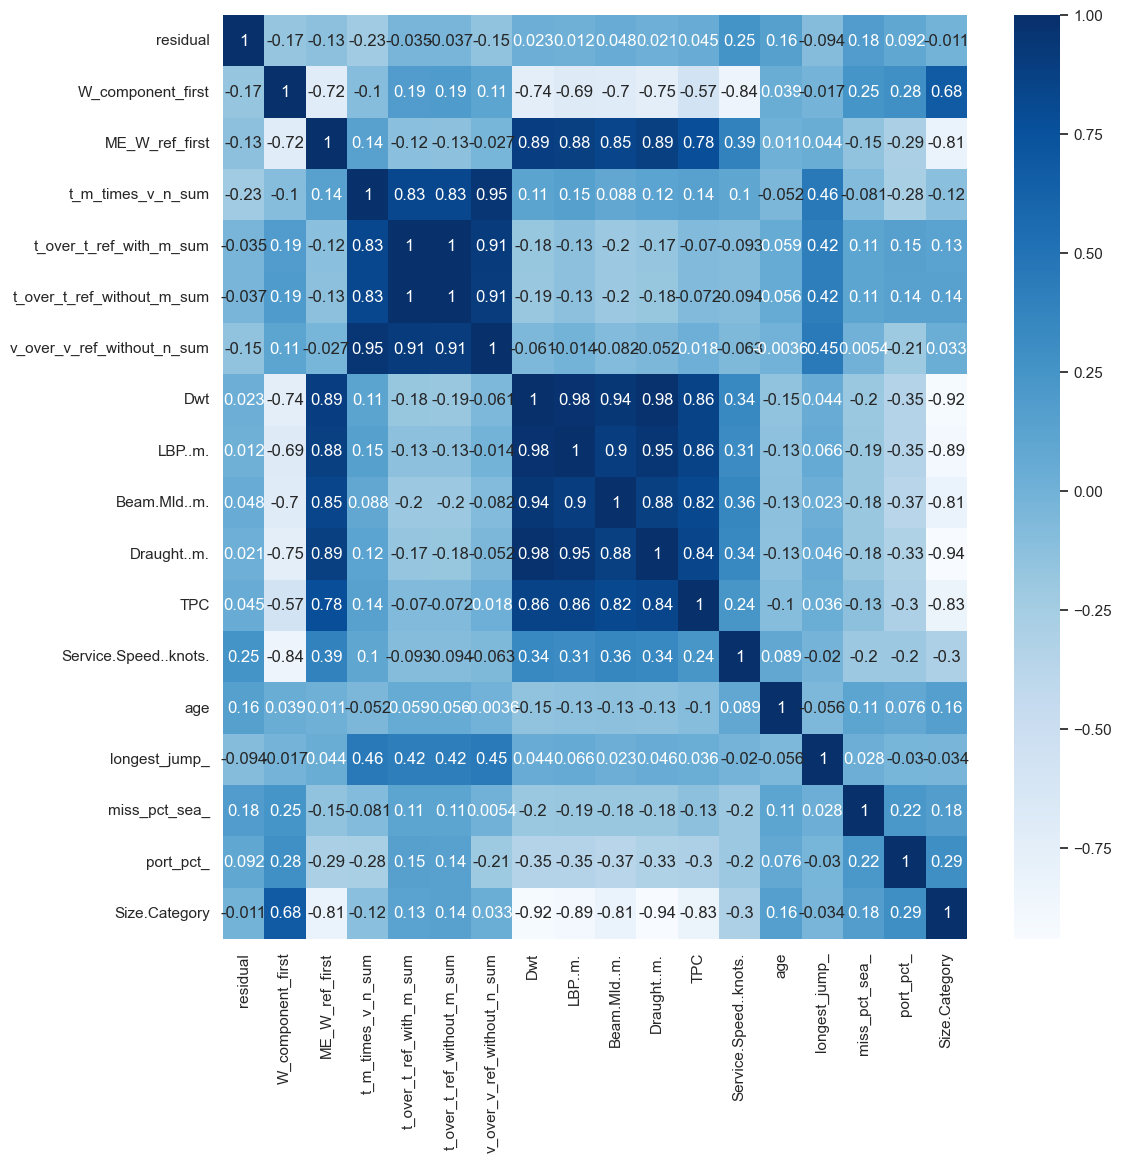

In [27]:
results_var = ['total.fc', 'FC_sum']
X_train, X_test, y_train, y_test = train_test_split(df_ml[features_1 + results_var], df_ml['residual'], test_size=0.3)
X_train.drop(columns=results_var, inplace=True)
y_train.drop(columns=results_var, inplace=True)
preprocessor_linear_adv.fit(X_train)
new_columns = (
    log_transform_cols_adv + ordinal_cols
)
X_train_enc = pd.DataFrame(
    preprocessor_linear_adv.transform(X_train), index=X_train.index, columns=new_columns
)
cor = pd.concat((y_train, X_train_enc), axis=1).iloc[:, :].corr()
plt.figure(figsize=(12, 12))
sns.set(font_scale=1)
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)

[]

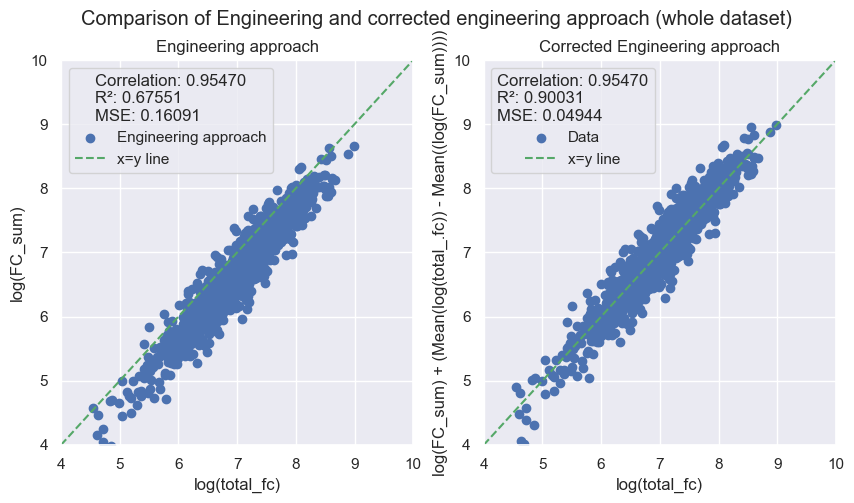

In [51]:
results_var = ['total.fc', 'FC_sum']
X_train, X_test, y_train, y_test = train_test_split(df_ml, df_ml['residual'], test_size=0.3)

# Convert pandas series to numpy arrays
total_fc = df_ml['total.fc'].values
FC_sum = df_ml['FC_sum'].values / 1000000
# Calculate mean of log(total_fc) and log(FC_sum)
mean_log_total_fc = np.mean(np.log(total_fc))
mean_log_FC_sum = np.mean(np.log(FC_sum))

# Generate x values and fitted y values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Comparison of Engineering and corrected engineering approach (whole dataset)')
x_values = np.log(total_fc)

r_squared_eng = r2_score(x_values, np.log(FC_sum))

# Calculate correlation
correlation_eng = np.corrcoef(x_values, np.log(FC_sum))[0, 1]

# Calculate mean squared error
mse_eng = mean_squared_error(x_values, np.log(FC_sum))

# Create a scatter plot
ax1.set_xlim(4, 10)
ax1.set_ylim(4, 10)
ax1.scatter(x_values, np.log(FC_sum), label='Engineering approach')
# Plot x=y reference line
ax1.plot([4, 10], [4, 10], 'g--', label='x=y line')

# Set x and y labels
ax1.set_xlabel('log(total_fc)')
ax1.set_ylabel('log(FC_sum)')

# Set a title for the plot
ax1.set_title("Engineering approach")

# Add details in legend about correlation, r-squared and mean squared error
legend_title = 'Correlation: {:.5f}\nR²: {:.5f}\nMSE: {:.5f}'.format(correlation_eng, r_squared_eng, mse_eng)
ax1.legend(title=legend_title)

# Show the plot
ax1.plot()
corrected_residual = np.log(FC_sum) + (mean_log_total_fc - mean_log_FC_sum)
# Calculate R-squared
r_squared_corr = r2_score(np.log(total_fc), corrected_residual)

# Calculate correlation
correlation_corr = np.corrcoef(np.log(total_fc), corrected_residual)[0, 1]

# Calculate mean squared error
mse_corr = mean_squared_error(np.log(total_fc), corrected_residual)
# Create a scatter plot
ax2.set_xlim(4, 10)
ax2.set_ylim(4, 10)
ax2.scatter(np.log(total_fc), corrected_residual, label='Data')

# Plot x=y reference line
ax2.plot([4, 10], [4, 10], 'g--', label='x=y line')

# Set x and y labels
ax2.set_xlabel('log(total_fc)')
ax2.set_ylabel('log(FC_sum) + (Mean(log(total_.fc)) - Mean((log(FC_sum))))')

# Set a title for the plot
ax2.set_title("Corrected Engineering approach")

# Add details in legend about correlation, r-squared and mean squared error
legend_title = 'Correlation: {:.5f}\nR²: {:.5f}\nMSE: {:.5f}'.format(correlation_corr, r_squared_corr, mse_corr)
ax2.legend(title=legend_title)

# Show the plot
ax2.plot()

In [28]:
X_train_enc

,W_component_first,ME_W_ref_first,t_m_times_v_n_sum,t_over_t_ref_with_m_sum,t_over_t_ref_without_m_sum,v_over_v_ref_without_n_sum,Dwt,LBP..m.,Beam.Mld..m.,Draught..m.,TPC,Service.Speed..knots.,age,longest_jump_,miss_pct_sea_,port_pct_,Size.Category
367,0.410641,-0.385936,1.259735,2.233638,2.212043,1.710124,-1.231558,-1.168048,-1.010004,-1.304828,-1.406825,0.341739,1.535020,-0.209858,-0.403226,1.102359,3.0
707,-0.202351,0.117666,-0.118639,-0.496994,-0.532599,-0.066197,0.004030,-0.354050,0.037049,0.143390,-0.105688,0.041988,0.350428,-1.058718,-0.265884,-0.923373,2.0
1010,-0.626746,1.175528,0.891583,0.348192,0.438322,0.598449,0.692463,0.712641,0.539301,0.718195,-0.131120,0.341739,-3.500617,0.947953,-1.319390,-1.566666,1.0
505,-1.547284,1.175528,-0.340664,-0.319519,-0.332477,-0.394124,1.095459,1.264652,1.812454,0.369792,1.617744,2.877514,0.197359,0.527019,-0.431364,-0.445078,0.0
508,-0.628334,1.175528,1.601049,0.995174,0.977575,1.420794,0.946671,1.036345,1.047131,0.721787,1.120088,0.341739,-0.161012,0.638721,0.512220,-1.100159,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1196,0.584715,-0.860070,-2.724032,-2.562991,-2.587149,-2.470733,-0.418137,-0.304596,-0.043578,-0.786875,-0.131120,-0.415067,-3.500617,-1.622591,-0.292851,0.415961,2.0
151,-0.088358,0.119844,-1.026741,-0.899266,-0.978338,-1.072556,-0.026410,-0.354050,0.037049,0.083305,-0.131120,-0.109360,0.490169,-0.571583,1.612139,0.971655,2.0
595,-0.620373,0.190544,0.556468,0.330363,0.418433,0.495832,0.623049,0.686967,0.037049,0.703806,0.492189,0.341739,0.197359,0.944457,0.350134,-1.696581,1.0
73,-0.816240,0.794098,-1.974767,-2.856915,-2.769938,-2.369721,0.323626,0.693653,0.031324,0.358305,0.082609,1.074515,2.383101,-2.928993,-0.934415,-2.028357,1.0


In [29]:
df_ml['residual'].describe()

count    1285.000000
mean        0.333301
std         0.221861
min        -0.438619
25%         0.205848
50%         0.334227
75%         0.459546
max         1.122524
Name: residual, dtype: float64

In [60]:
log_transform_cols_adv_1 = ["miss_pct_sea_"]
preprocessor_linear_adv_1 = ColumnTransformer(
    transformers=[
        ('impute_scale_transform', impute_scale_transform, log_transform_cols_adv_1),
        ])
pipe1 = make_pipeline(preprocessor_linear_adv_1, LinearRegression())
pipe1.fit(X_train, y_train)
print(pd.DataFrame(data=pipe1[1].coef_, columns=['coefficient'], index=log_transform_cols_adv_1))
print(pipe1[1].intercept_)


               coefficient
miss_pct_sea_     0.046322
0.33692173408334014


In [63]:
# Standard Error for LinearRegressor

y_pred = pipe1.predict(X_train)
residuals = y_train - y_pred
mse = np.mean(residuals**2)
X_train_np = preprocessor_linear_adv_1.fit_transform(X_train)
X_with_intercept = np.append(np.ones((X_train_np.shape[0], 1)), X_train_np, axis=1)
var_beta = mse * np.linalg.inv(np.dot(X_with_intercept.T, X_with_intercept)).diagonal()
std_errors = np.sqrt(var_beta)
print(pd.DataFrame(data=std_errors, columns=['std_error']))


   std_error
0   0.007276
1   0.007276


In [31]:
# Hyperparameter tuning for Ridge
param_grid_ridge = {
        'ridge__alpha':[0.1, 0.01, 0.001, 0.0001, 1, 10, 100, 1000, 10000, 100000]
}

model_ridge = Ridge()
pipe_ridge = make_pipeline(preprocessor_linear_adv, model_ridge)

grid_search_ridge =  GridSearchCV(pipe_ridge, param_grid_ridge, cv=10, scoring='r2', n_jobs=-1)
grid_search_ridge.fit(X_train, y_train)

result_ridge = pd.DataFrame(grid_search_ridge.cv_results_)[
    [
        "mean_test_score",
        "param_ridge__alpha",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T

print(result_ridge)

print(f"Best parameters for Ridge is: {grid_search_ridge.best_params_}")
print(f"Best score for Ridge is: {grid_search_ridge.best_score_}")
print(f"Test score for Ridge is: {grid_search_ridge.score(X_test, y_test)}")

rank_test_score           1         2         3         4         5   \
mean_test_score     0.597225  0.596761   0.59667   0.59666  0.596626   
param_ridge__alpha       0.1      0.01     0.001    0.0001         1   
mean_fit_time       0.007886  0.006038  0.003949  0.012892  0.004908   

rank_test_score           6         7         8         9         10  
mean_test_score     0.576677  0.429236  0.165103  0.025459 -0.004179  
param_ridge__alpha        10       100      1000     10000    100000  
mean_fit_time       0.003574  0.003586   0.00338  0.003428  0.003423  
Best parameters for Ridge is: {'ridge__alpha': 0.1}
Best score for Ridge is: 0.5972246108037393
Test score for Ridge is: 0.6516919393268724


In [33]:
# Hyperparameter tuning for Lasso
param_grid_lasso = {
        'lasso__alpha':[0.00001,0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
}

model_lasso = Lasso(max_iter=1000000)
pipe_lasso = make_pipeline(preprocessor_linear_adv, model_lasso)

grid_search_lasso =  GridSearchCV(pipe_lasso, param_grid_lasso, cv=10, scoring='r2', n_jobs=-1)
grid_search_lasso.fit(X_train, y_train)

result_lasso = pd.DataFrame(grid_search_lasso.cv_results_)[
    [
        "mean_test_score",
        "param_lasso__alpha",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T

print(result_lasso)

print(f"Best parameters for Lasso is: {grid_search_lasso.best_params_}")
print(f"Best score for Lasso is: {grid_search_lasso.best_score_}")
print(f"Test score for Lasso is: {grid_search_lasso.score(X_test, y_test)}")

rank_test_score            1         2         2         4         5  \
mean_test_score     0.597087  0.596778  0.596778  0.594212  0.397887   
param_lasso__alpha    0.0001   0.00001   0.00001     0.001      0.01   
mean_fit_time       0.049451  0.106565  0.103522  0.014658  0.005131   

rank_test_score            6         6         6         6  
mean_test_score    -0.008035 -0.008035 -0.008035 -0.008035  
param_lasso__alpha       0.1         1        10       100  
mean_fit_time       0.004151  0.004588  0.003814  0.003993  
Best parameters for Lasso is: {'lasso__alpha': 0.0001}
Best score for Lasso is: 0.5970866265470964
Test score for Lasso is: 0.649876133461928


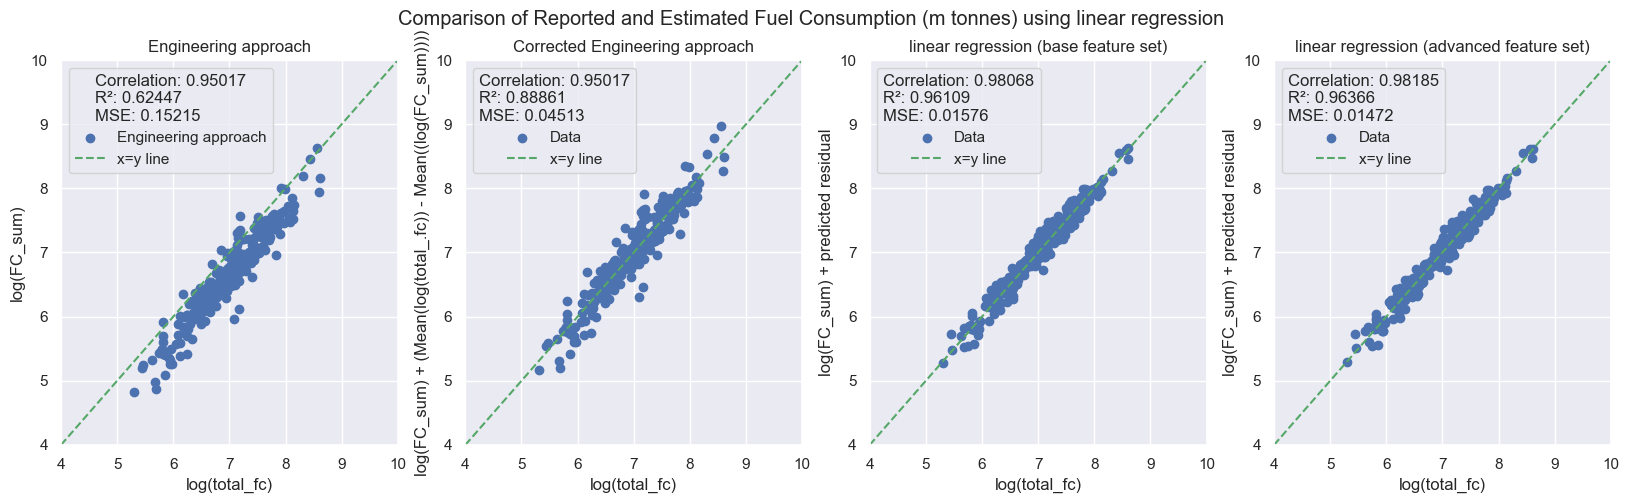

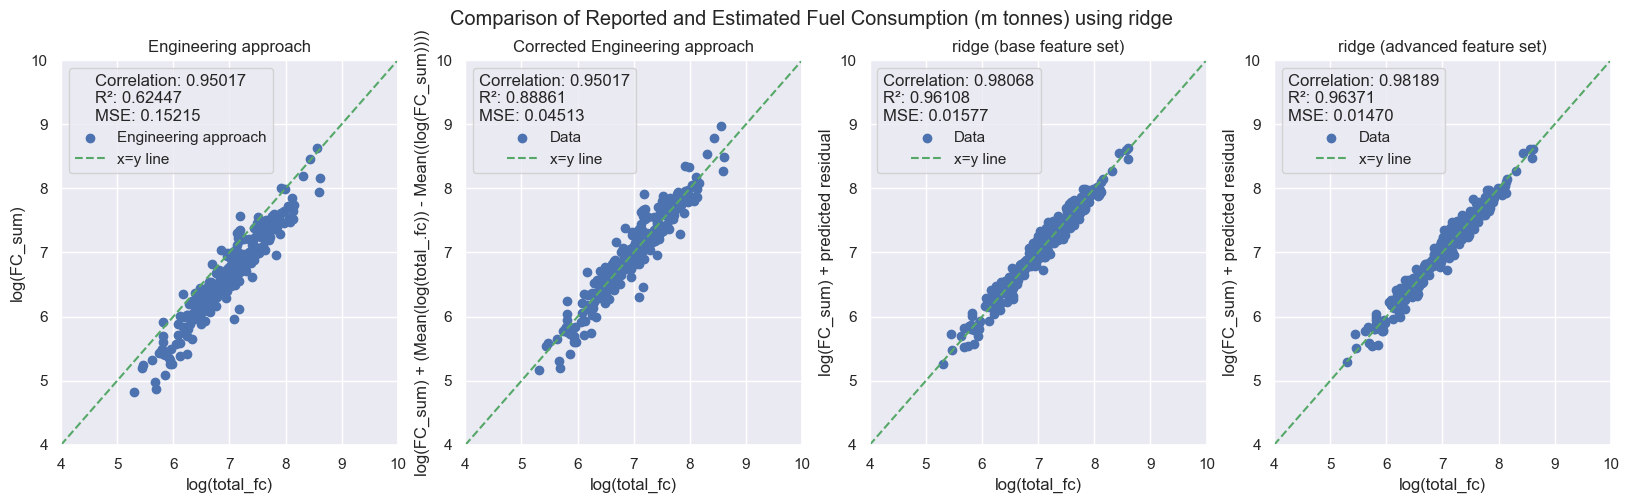

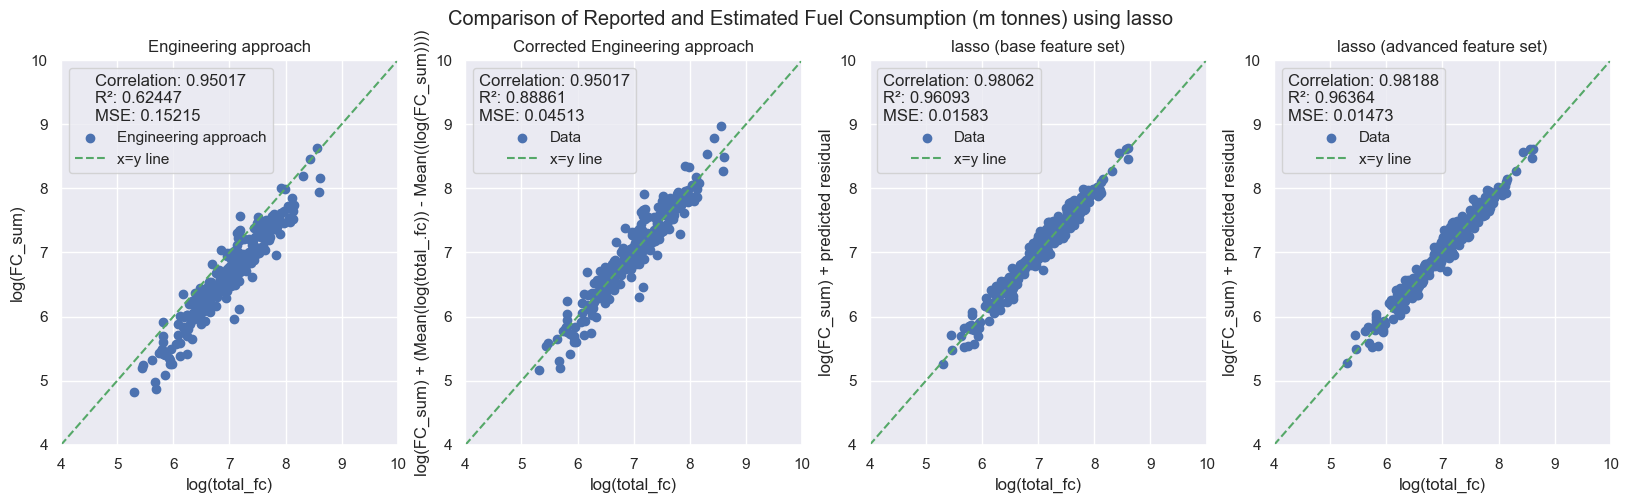

In [39]:
results_var = ['total.fc', 'FC_sum']
models = {
    "linear regression": LinearRegression(),
    "ridge": Ridge(alpha=0.1),
    "lasso": Lasso(max_iter=1000000, alpha= 0.0001)
}



X_train, X_test, y_train, y_test = train_test_split(df_ml[features_1 + results_var], df_ml['residual'], test_size=0.2)
total_fc = X_test['total.fc'].values
FC_sum = X_test['FC_sum'].values / 1000000
total_fc_train = X_train['total.fc'].values
FC_sum_train = X_train['FC_sum'].values / 1000000
X_train.drop(columns=results_var, inplace=True)
X_test.drop(columns=results_var, inplace=True)
mean_log_total_fc = np.mean(np.log(total_fc_train))
mean_log_FC_sum = np.mean(np.log(FC_sum_train))
for model in models:
    columns = ['Model', 'r2', 'correlation', 'MSE', 'r2_residual', 'correlation_residual', 'MSE_residual']
    test_results = pd.DataFrame(columns=columns)
        

    pipe = make_pipeline(preprocessor_linear, models[model])

    pipe.fit(X_train, y_train)

    # Generate x values and fitted y values
    predicted_residual = pipe.predict(X_test)

    y_values = np.log(FC_sum) + predicted_residual
    x_values = np.log(total_fc)


    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))
    x_values = np.log(total_fc)
    fig.suptitle('Comparison of Reported and Estimated Fuel Consumption (m tonnes) using ' + model)
    r_squared_eng = r2_score(x_values, np.log(FC_sum))

    # Calculate correlation
    correlation_eng = np.corrcoef(x_values, np.log(FC_sum))[0, 1]

    # Calculate mean squared error
    mse_eng = mean_squared_error(x_values, np.log(FC_sum))
    
    # Create a scatter plot
    ax1.set_xlim(4, 10)
    ax1.set_ylim(4, 10)
    ax1.scatter(x_values, np.log(FC_sum), label='Engineering approach')
    # Plot x=y reference line
    ax1.plot([4, 10], [4, 10], 'g--', label='x=y line')

    # Set x and y labels
    ax1.set_xlabel('log(total_fc)')
    ax1.set_ylabel('log(FC_sum)')

    # Set a title for the plot
    ax1.set_title("Engineering approach")

    # Add details in legend about correlation, r-squared and mean squared error
    legend_title = 'Correlation: {:.5f}\nR²: {:.5f}\nMSE: {:.5f}'.format(correlation_eng, r_squared_eng, mse_eng)
    ax1.legend(title=legend_title)

    # Show the plot
    ax1.plot()
    corrected_residual = np.log(FC_sum) + (mean_log_total_fc - mean_log_FC_sum)
    # Calculate R-squared
    r_squared_corr = r2_score(np.log(total_fc), corrected_residual)

    # Calculate correlation
    correlation_corr = np.corrcoef(np.log(total_fc), corrected_residual)[0, 1]

    # Calculate mean squared error
    mse_corr = mean_squared_error(np.log(total_fc), corrected_residual)
    # Create a scatter plot
    ax2.set_xlim(4, 10)
    ax2.set_ylim(4, 10)
    ax2.scatter(np.log(total_fc), corrected_residual, label='Data')

    # Plot x=y reference line
    ax2.plot([4, 10], [4, 10], 'g--', label='x=y line')

    # Set x and y labels
    ax2.set_xlabel('log(total_fc)')
    ax2.set_ylabel('log(FC_sum) + (Mean(log(total_.fc)) - Mean((log(FC_sum))))')

    # Set a title for the plot
    ax2.set_title("Corrected Engineering approach")

    # Add details in legend about correlation, r-squared and mean squared error
    legend_title = 'Correlation: {:.5f}\nR²: {:.5f}\nMSE: {:.5f}'.format(correlation_corr, r_squared_corr, mse_corr)
    ax2.legend(title=legend_title)

    # Show the plot
    ax2.plot()
    # Calculate R-squared
    r_squared_mod = r2_score(x_values, y_values)

    # Calculate correlation
    correlation_mod = np.corrcoef(x_values, y_values)[0, 1]

    # Calculate mean squared error
    mse_mod = mean_squared_error(x_values, y_values)
    
    # Create a scatter plot
    #plt.figure(figsize=(10, 8))
    ax3.set_xlim(4, 10)
    ax3.set_ylim(4, 10)
    ax3.scatter(x_values, y_values, label='Data')

    # Plot x=y reference line
    ax3.plot([4, 10], [4, 10], 'g--', label='x=y line')

    # Set x and y labels
    ax3.set_xlabel('log(total_fc)')
    ax3.set_ylabel('log(FC_sum) + predicted residual')

    # Set a title for the plot
    ax3.set_title(model + " (base feature set)")

    # Add details in legend about correlation, r-squared and mean squared error
    legend_title = 'Correlation: {:.5f}\nR²: {:.5f}\nMSE: {:.5f}'.format(correlation_mod, r_squared_mod, mse_mod)
    ax3.legend(title=legend_title)

    # Show the plot
    ax3.plot()



    pipe_adv = make_pipeline(preprocessor_linear_adv, models[model])

    pipe_adv.fit(X_train, y_train)

    # Generate x values and fitted y values
    predicted_residual_adv = pipe_adv.predict(X_test)

    y_values_adv = np.log(FC_sum) + predicted_residual_adv
    r_squared_mod_adv = r2_score(x_values, y_values_adv)

    # Calculate correlation
    correlation_mod_adv = np.corrcoef(x_values, y_values_adv)[0, 1]

    # Calculate mean squared error
    mse_mod_adv = mean_squared_error(x_values, y_values_adv)
    
    # Create a scatter plot
    #plt.figure(figsize=(10, 8))
    ax4.set_xlim(4, 10)
    ax4.set_ylim(4, 10)
    ax4.scatter(x_values, y_values_adv, label='Data')

    # Plot x=y reference line
    ax4.plot([4, 10], [4, 10], 'g--', label='x=y line')

    # Set x and y labels
    ax4.set_xlabel('log(total_fc)')
    ax4.set_ylabel('log(FC_sum) + predicted residual')

    # Set a title for the plot
    ax4.set_title(model + " (advanced feature set)")

    # Add details in legend about correlation, r-squared and mean squared error
    legend_title = 'Correlation: {:.5f}\nR²: {:.5f}\nMSE: {:.5f}'.format(correlation_mod_adv, r_squared_mod_adv, mse_mod_adv)
    ax4.legend(title=legend_title)

    # Show the plot
    ax4.plot()



In [36]:
# Hyperparameter tuning for CatBoostRegressor
param_grid_pipe_catboostregressor = {
    'catboostregressor__depth': [4, 6, 7, 8, 9 ,10],
    'catboostregressor__iterations': [10, 30, 50, 100, 500],
    'catboostregressor__l2_leaf_reg': [1, 5, 7, 9, 11, 15]
}

model_catboostregressor = CatBoostRegressor(verbose = 0)
pipe_catboostregressor = make_pipeline(preprocessor_linear_adv, model_catboostregressor)

grid_search_catboostregressor = RandomizedSearchCV(pipe_catboostregressor, param_grid_pipe_catboostregressor, n_iter=30, cv=5, scoring='r2', n_jobs=-1)
grid_search_catboostregressor.fit(X_train, y_train)

# result_catboostregressor = pd.DataFrame(grid_search_catboostregressor.cv_results_)[
#     [
#         "mean_test_score",
#         "param_catboostregressor__depth",
#         "param_catboostregressor__learning_rate",
#         "param_catboostregressor__iterations",
#         "param_catboostregressor__l2_leaf_reg",
#         "mean_fit_time",
#         "rank_test_score",
#     ]
# ].set_index("rank_test_score").sort_index().T

# print(result_catboostregressor)

print(f"Best parameters for CatBoostRegressor is: {grid_search_catboostregressor.best_params_}")
print(f"Best score for CatBoostRegressor is: {grid_search_catboostregressor.best_score_}")
print(f"Test score for CatBoostRegressor is: {grid_search_catboostregressor.score(X_test, y_test)}")

Best parameters for CatBoostRegressor is: {'catboostregressor__l2_leaf_reg': 5, 'catboostregressor__iterations': 500, 'catboostregressor__depth': 8}
Best score for CatBoostRegressor is: 0.4689274033301162
Test score for CatBoostRegressor is: 0.5250136531758316


In [37]:
# Hyperparameter tuning for RandomForestRegressor
param_grid_randomforestregressor = {
        'randomforestregressor__n_estimators': [50, 100, 200, 300, 500, 700, 1000],
        'randomforestregressor__max_depth': [10, 20, 30, 40, 50, None],
}

model_randomforestregressor = RandomForestRegressor()
pipe_randomforestregressor = make_pipeline(preprocessor_linear_adv, model_randomforestregressor)

grid_search_randomforestregressor =  GridSearchCV(pipe_randomforestregressor, param_grid_randomforestregressor, cv=5, scoring='r2', n_jobs=-1)
grid_search_randomforestregressor.fit(X_train, y_train)

result_randomforestregressor = pd.DataFrame(grid_search_randomforestregressor.cv_results_)[
    [
        "mean_test_score",
        "param_randomforestregressor__n_estimators",
        "param_randomforestregressor__max_depth",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T

print(result_randomforestregressor)

print(f"Best parameters for RandomForestRegressor is: {grid_search_randomforestregressor.best_params_}")
print(f"Best score for RandomForestRegressor is: {grid_search_randomforestregressor.best_score_}")
print(f"Test score for RandomForestRegressor is: {grid_search_randomforestregressor.score(X_test, y_test)}")

rank_test_score                                  1         2         3   \
mean_test_score                            0.427448  0.427013  0.426656   
param_randomforestregressor__n_estimators       200       700       700   
param_randomforestregressor__max_depth           50      None        30   
mean_fit_time                              1.074871  3.556213  3.652804   

rank_test_score                                  4         5         6   \
mean_test_score                            0.426555  0.426492  0.426353   
param_randomforestregressor__n_estimators       700      1000      1000   
param_randomforestregressor__max_depth           20        50        20   
mean_fit_time                              3.739237  5.391927  5.278877   

rank_test_score                                  7         8         9   \
mean_test_score                            0.426033  0.425986  0.425886   
param_randomforestregressor__n_estimators      1000      1000       500   
param_randomforestregre

In [52]:
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor
## Multiple rounds tests for model performance
log_transform_cols_adv_1 = ["longest_jump_", "miss_pct_sea_", "port_pct_"]
preprocessor_linear_adv = ColumnTransformer(
    transformers=[
        ('impute_scale_transform', impute_scale_transform, log_transform_cols_adv_1),
        ])
results_var = ['total.fc', 'FC_sum']
models = {
    "linear regression": LinearRegression(),
    "ridge": Ridge(alpha=0.01),
    "lasso": Lasso(max_iter=100000, alpha= 0.00001),
    "random forest": RandomForestRegressor(max_depth=50, n_estimators=200),
    "catboost": CatBoostRegressor(depth=8, l2_leaf_reg=5, iterations=500, verbose = 0),
    "gbdt": GradientBoostingRegressor()
}
for model in models:
    columns = ['Model', 'r2', 'correlation', 'MSE']
    test_results = pd.DataFrame(columns=columns)
    test_results_adv = pd.DataFrame(columns=columns)
    for i in range(0,100):
        X_train, X_test, y_train, y_test = train_test_split(df_ml[features_1 + results_var], df_ml['residual'], test_size=0.3)
        pipe = make_pipeline(preprocessor_linear, models[model])
        total_fc = X_test['total.fc'].values
        FC_sum = X_test['FC_sum'].values / 1000000
        X_train.drop(columns=results_var, inplace=True)
        X_test.drop(columns=results_var, inplace=True)
        pipe.fit(X_train, y_train)

        # Generate x values and fitted y values
        predicted_residual = pipe.predict(X_test)

        y_values = np.log(FC_sum) + predicted_residual
        x_values = np.log(total_fc)
        # Calculate R-squared
        r_squared = r2_score(x_values, y_values)

        # Calculate correlation
        correlation = np.corrcoef(x_values, y_values)[0, 1]

        # Calculate mean squared error
        mse = mean_squared_error(x_values, y_values)
        
         # Calculate R-squared for residual
        # r_squared_r = r2_score(y_test, predicted_residual)

        # # Calculate correlation
        # correlation_r = np.corrcoef(y_test, predicted_residual)[0, 1]

        # # Calculate mean squared error
        # mse_r = mean_squared_error(y_test, predicted_residual)
        new_row = pd.DataFrame({'Model': [model],'r2':[r_squared], 'correlation':[correlation], 'MSE':[mse]})

        # Appending the new row
        test_results = pd.concat([test_results, new_row], ignore_index=True)

        pipe_2 = make_pipeline(preprocessor_linear_adv, models[model])

        pipe_2.fit(X_train, y_train)

        # Generate x values and fitted y values
        predicted_residual_adv = pipe_2.predict(X_test)

        y_values_adv = np.log(FC_sum) + predicted_residual_adv
        r_squared_mod_adv = r2_score(x_values, y_values_adv)

        # Calculate correlation
        correlation_mod_adv = np.corrcoef(x_values, y_values_adv)[0, 1]

        # Calculate mean squared error
        mse_mod_adv = mean_squared_error(x_values, y_values_adv)
        new_row_adv = pd.DataFrame({'Model': [model],'r2':[r_squared_mod_adv], 'correlation':[correlation_mod_adv], 'MSE':[mse_mod_adv]})
        test_results_adv = pd.concat([test_results_adv, new_row_adv], ignore_index=True)


    mean = test_results['r2'].mean()
    std_dev = test_results['r2'].std()
    mean_mse = test_results['MSE'].mean()
    std_mse = test_results['MSE'].std()
    mean_adv = test_results_adv['r2'].mean()
    std_dev_adv = test_results_adv['r2'].std()
    mean_mse_adv = test_results_adv['MSE'].mean()
    std_mse_adv = test_results_adv['MSE'].std()

    print(f"Model: {model}, Mean for r2: {mean:.5f}, Standard Deviation for r2: {std_dev:.5f}, Mean for MSE:{mean_mse:.5f}, Standard Deviation for MSE: {std_mse:.5f}")
    print(f"Model: {model} (Advanced Feature Set), Mean for r2: {mean_adv:.5f}, Standard Deviation for r2: {std_dev_adv:.5f}, Mean for MSE:{mean_mse_adv:.5f}, Standard Deviation for MSE: {std_mse_adv:.5f}")

    
    

Model: linear regression, Mean for r2: 0.95935, Standard Deviation for r2: 0.00491, Mean for MSE:0.01999, Standard Deviation for MSE: 0.00192
Model: linear regression (Advanced Feature Set), Mean for r2: 0.90408, Standard Deviation for r2: 0.01042, Mean for MSE:0.04716, Standard Deviation for MSE: 0.00354
Model: ridge, Mean for r2: 0.96012, Standard Deviation for r2: 0.00391, Mean for MSE:0.01965, Standard Deviation for MSE: 0.00162
Model: ridge (Advanced Feature Set), Mean for r2: 0.90473, Standard Deviation for r2: 0.01042, Mean for MSE:0.04685, Standard Deviation for MSE: 0.00340
Model: lasso, Mean for r2: 0.96021, Standard Deviation for r2: 0.00404, Mean for MSE:0.01950, Standard Deviation for MSE: 0.00182
Model: lasso (Advanced Feature Set), Mean for r2: 0.90470, Standard Deviation for r2: 0.00846, Mean for MSE:0.04668, Standard Deviation for MSE: 0.00333


KeyboardInterrupt: 

Model: linear regression, Mean for r2: 0.95988, Standard Deviation for r2: 0.00429, Mean for MSE:0.01975, Standard Deviation for MSE: 0.00172
Model: linear regression (Advanced Feature Set), Mean for r2: 0.96183, Standard Deviation for r2: 0.00412, Mean for MSE:0.01879, Standard Deviation for MSE: 0.00169
Model: ridge, Mean for r2: 0.95943, Standard Deviation for r2: 0.00457, Mean for MSE:0.01991, Standard Deviation for MSE: 0.00178
Model: ridge (Advanced Feature Set), Mean for r2: 0.96142, Standard Deviation for r2: 0.00433, Mean for MSE:0.01893, Standard Deviation for MSE: 0.00171
Model: lasso, Mean for r2: 0.95967, Standard Deviation for r2: 0.00419, Mean for MSE:0.01986, Standard Deviation for MSE: 0.00173
Model: lasso (Advanced Feature Set), Mean for r2: 0.96158, Standard Deviation for r2: 0.00404, Mean for MSE:0.01892, Standard Deviation for MSE: 0.00170
Model: random forest, Mean for r2: 0.94477, Standard Deviation for r2: 0.00593, Mean for MSE:0.02726, Standard Deviation for MSE: 0.00220
Model: random forest (Advanced Feature Set), Mean for r2: 0.94260, Standard Deviation for r2: 0.00611, Mean for MSE:0.02834, Standard Deviation for MSE: 0.00237
Model: catboost, Mean for r2: 0.94991, Standard Deviation for r2: 0.00535, Mean for MSE:0.02463, Standard Deviation for MSE: 0.00210
Model: catboost (Advanced Feature Set), Mean for r2: 0.94767, Standard Deviation for r2: 0.00564, Mean for MSE:0.02574, Standard Deviation for MSE: 0.00224
Model: gbdt, Mean for r2: 0.94673, Standard Deviation for r2: 0.00552, Mean for MSE:0.02622, Standard Deviation for MSE: 0.00219
Model: gbdt (Advanced Feature Set), Mean for r2: 0.94661, Standard Deviation for r2: 0.00563, Mean for MSE:0.02628, Standard Deviation for MSE: 0.00230

In [75]:
## Multiple rounds tests for model performance
log_transform_cols_jump = ["W_component_first", "ME_W_ref_first", "t_m_times_v_n_sum",
                      "t_over_t_ref_with_m_sum", "t_over_t_ref_without_m_sum",
                      "v_over_v_ref_without_n_sum", "Dwt", "LBP..m.",
                      "Beam.Mld..m.", "Draught..m.", "TPC",
                      "Service.Speed..knots.", "age", "longest_jump_"]
preprocessor_linear_jump = ColumnTransformer(
    transformers=[
        ('impute_scale_transform', impute_scale_transform, log_transform_cols_jump),
        ('ordinal', ordinal_transformer, ordinal_cols),
        ])
results_var = ['total.fc', 'FC_sum']
models = {
    "linear regression": LinearRegression(),
    "ridge": Ridge(alpha=0.01),
    "lasso": Lasso(max_iter=100000, alpha= 0.00001)
}
for model in models:
    columns = ['Model', 'r2', 'correlation', 'MSE']
    test_results = pd.DataFrame(columns=columns)
    test_results_adv = pd.DataFrame(columns=columns)
    for i in range(0,500):
        X_train, X_test, y_train, y_test = train_test_split(df_ml[features_1 + results_var], df_ml['residual'], test_size=0.3)
        pipe = make_pipeline(preprocessor_linear, models[model])
        total_fc = X_test['total.fc'].values
        FC_sum = X_test['FC_sum'].values / 1000000
        X_train.drop(columns=results_var, inplace=True)
        X_test.drop(columns=results_var, inplace=True)
        pipe.fit(X_train, y_train)

        # Generate x values and fitted y values
        predicted_residual = pipe.predict(X_test)

        y_values = np.log(FC_sum) + predicted_residual
        x_values = np.log(total_fc)
        # Calculate R-squared
        r_squared = r2_score(x_values, y_values)

        # Calculate correlation
        correlation = np.corrcoef(x_values, y_values)[0, 1]

        # Calculate mean squared error
        mse = mean_squared_error(x_values, y_values)
        
         # Calculate R-squared for residual
        # r_squared_r = r2_score(y_test, predicted_residual)

        # # Calculate correlation
        # correlation_r = np.corrcoef(y_test, predicted_residual)[0, 1]

        # # Calculate mean squared error
        # mse_r = mean_squared_error(y_test, predicted_residual)
        new_row = pd.DataFrame({'Model': [model],'r2':[r_squared], 'correlation':[correlation], 'MSE':[mse]})

        # Appending the new row
        test_results = pd.concat([test_results, new_row], ignore_index=True)

        pipe_2 = make_pipeline(preprocessor_linear_jump, models[model])

        pipe_2.fit(X_train, y_train)

        # Generate x values and fitted y values
        predicted_residual_adv = pipe_2.predict(X_test)

        y_values_adv = np.log(FC_sum) + predicted_residual_adv
        r_squared_mod_adv = r2_score(x_values, y_values_adv)

        # Calculate correlation
        correlation_mod_adv = np.corrcoef(x_values, y_values_adv)[0, 1]

        # Calculate mean squared error
        mse_mod_adv = mean_squared_error(x_values, y_values_adv)
        new_row_adv = pd.DataFrame({'Model': [model],'r2':[r_squared_mod_adv], 'correlation':[correlation_mod_adv], 'MSE':[mse_mod_adv]})
        test_results_adv = pd.concat([test_results_adv, new_row_adv], ignore_index=True)

    #print(test_results)
    mean = test_results['r2'].mean()
    std_dev = test_results['r2'].std()
    mean_mse = test_results['MSE'].mean()
    std_mse = test_results['MSE'].std()
    mean_adv = test_results_adv['r2'].mean()
    std_dev_adv = test_results_adv['r2'].std()
    mean_mse_adv = test_results_adv['MSE'].mean()
    std_mse_adv = test_results_adv['MSE'].std()

    print(f"Model: {model}, Mean for r2: {mean:.5f}, Standard Deviation for r2: {std_dev:.5f}, Mean for MSE:{mean_mse:.5f}, Standard Deviation for MSE: {std_mse:.5f}")
    print(f"Model: {model} (Advanced Feature Set), Mean for r2: {mean_adv:.5f}, Standard Deviation for r2: {std_dev_adv:.5f}, Mean for MSE:{mean_mse_adv:.5f}, Standard Deviation for MSE: {std_mse_adv:.5f}")

    
    

Model: linear regression, Mean for r2: 0.92411, Standard Deviation for r2: 0.02684, Mean for MSE:0.03756, Standard Deviation for MSE: 0.01292
Model: linear regression (Advanced Feature Set), Mean for r2: 0.92398, Standard Deviation for r2: 0.02695, Mean for MSE:0.03762, Standard Deviation for MSE: 0.01297
Model: ridge, Mean for r2: 0.92355, Standard Deviation for r2: 0.02683, Mean for MSE:0.03791, Standard Deviation for MSE: 0.01313
Model: ridge (Advanced Feature Set), Mean for r2: 0.92342, Standard Deviation for r2: 0.02694, Mean for MSE:0.03797, Standard Deviation for MSE: 0.01319
Model: lasso, Mean for r2: 0.92232, Standard Deviation for r2: 0.02785, Mean for MSE:0.03852, Standard Deviation for MSE: 0.01377
Model: lasso (Advanced Feature Set), Mean for r2: 0.92217, Standard Deviation for r2: 0.02797, Mean for MSE:0.03859, Standard Deviation for MSE: 0.01382


In [76]:
## Multiple rounds tests for model performance
log_transform_cols_sea = ["W_component_first", "ME_W_ref_first", "t_m_times_v_n_sum",
                      "t_over_t_ref_with_m_sum", "t_over_t_ref_without_m_sum",
                      "v_over_v_ref_without_n_sum", "Dwt", "LBP..m.",
                      "Beam.Mld..m.", "Draught..m.", "TPC",
                      "Service.Speed..knots.", "age", "miss_pct_sea_"]
preprocessor_linear_sea = ColumnTransformer(
    transformers=[
        ('impute_scale_transform', impute_scale_transform, log_transform_cols_sea),
        ('ordinal', ordinal_transformer, ordinal_cols),
        ])
results_var = ['total.fc', 'FC_sum']
models = {
    "linear regression": LinearRegression(),
    "ridge": Ridge(alpha=0.01),
    "lasso": Lasso(max_iter=100000, alpha= 0.00001)
}
for model in models:
    columns = ['Model', 'r2', 'correlation', 'MSE']
    test_results = pd.DataFrame(columns=columns)
    test_results_adv = pd.DataFrame(columns=columns)
    for i in range(0,500):
        X_train, X_test, y_train, y_test = train_test_split(df_ml[features_1 + results_var], df_ml['residual'], test_size=0.3)
        pipe = make_pipeline(preprocessor_linear, models[model])
        total_fc = X_test['total.fc'].values
        FC_sum = X_test['FC_sum'].values / 1000000
        X_train.drop(columns=results_var, inplace=True)
        X_test.drop(columns=results_var, inplace=True)
        pipe.fit(X_train, y_train)

        # Generate x values and fitted y values
        predicted_residual = pipe.predict(X_test)

        y_values = np.log(FC_sum) + predicted_residual
        x_values = np.log(total_fc)
        # Calculate R-squared
        r_squared = r2_score(x_values, y_values)

        # Calculate correlation
        correlation = np.corrcoef(x_values, y_values)[0, 1]

        # Calculate mean squared error
        mse = mean_squared_error(x_values, y_values)
        
         # Calculate R-squared for residual
        # r_squared_r = r2_score(y_test, predicted_residual)

        # # Calculate correlation
        # correlation_r = np.corrcoef(y_test, predicted_residual)[0, 1]

        # # Calculate mean squared error
        # mse_r = mean_squared_error(y_test, predicted_residual)
        new_row = pd.DataFrame({'Model': [model],'r2':[r_squared], 'correlation':[correlation], 'MSE':[mse]})

        # Appending the new row
        test_results = pd.concat([test_results, new_row], ignore_index=True)

        pipe_2 = make_pipeline(preprocessor_linear_sea, models[model])

        pipe_2.fit(X_train, y_train)

        # Generate x values and fitted y values
        predicted_residual_adv = pipe_2.predict(X_test)

        y_values_adv = np.log(FC_sum) + predicted_residual_adv
        r_squared_mod_adv = r2_score(x_values, y_values_adv)

        # Calculate correlation
        correlation_mod_adv = np.corrcoef(x_values, y_values_adv)[0, 1]

        # Calculate mean squared error
        mse_mod_adv = mean_squared_error(x_values, y_values_adv)
        new_row_adv = pd.DataFrame({'Model': [model],'r2':[r_squared_mod_adv], 'correlation':[correlation_mod_adv], 'MSE':[mse_mod_adv]})
        test_results_adv = pd.concat([test_results_adv, new_row_adv], ignore_index=True)

    #print(test_results)
    mean = test_results['r2'].mean()
    std_dev = test_results['r2'].std()
    mean_mse = test_results['MSE'].mean()
    std_mse = test_results['MSE'].std()
    mean_adv = test_results_adv['r2'].mean()
    std_dev_adv = test_results_adv['r2'].std()
    mean_mse_adv = test_results_adv['MSE'].mean()
    std_mse_adv = test_results_adv['MSE'].std()

    print(f"Model: {model}, Mean for r2: {mean:.5f}, Standard Deviation for r2: {std_dev:.5f}, Mean for MSE:{mean_mse:.5f}, Standard Deviation for MSE: {std_mse:.5f}")
    print(f"Model: {model} (Advanced Feature Set), Mean for r2: {mean_adv:.5f}, Standard Deviation for r2: {std_dev_adv:.5f}, Mean for MSE:{mean_mse_adv:.5f}, Standard Deviation for MSE: {std_mse_adv:.5f}")

    
    

Model: linear regression, Mean for r2: 0.92207, Standard Deviation for r2: 0.02891, Mean for MSE:0.03878, Standard Deviation for MSE: 0.01407
Model: linear regression (Advanced Feature Set), Mean for r2: 0.92270, Standard Deviation for r2: 0.02939, Mean for MSE:0.03847, Standard Deviation for MSE: 0.01432
Model: ridge, Mean for r2: 0.92251, Standard Deviation for r2: 0.02701, Mean for MSE:0.03859, Standard Deviation for MSE: 0.01342
Model: ridge (Advanced Feature Set), Mean for r2: 0.92306, Standard Deviation for r2: 0.02735, Mean for MSE:0.03832, Standard Deviation for MSE: 0.01359
Model: lasso, Mean for r2: 0.92409, Standard Deviation for r2: 0.02794, Mean for MSE:0.03747, Standard Deviation for MSE: 0.01350
Model: lasso (Advanced Feature Set), Mean for r2: 0.92482, Standard Deviation for r2: 0.02824, Mean for MSE:0.03711, Standard Deviation for MSE: 0.01366


In [77]:
## Multiple rounds tests for model performance
log_transform_cols_port = ["W_component_first", "ME_W_ref_first", "t_m_times_v_n_sum",
                      "t_over_t_ref_with_m_sum", "t_over_t_ref_without_m_sum",
                      "v_over_v_ref_without_n_sum", "Dwt", "LBP..m.",
                      "Beam.Mld..m.", "Draught..m.", "TPC",
                      "Service.Speed..knots.", "age", "port_pct_"]
preprocessor_linear_port = ColumnTransformer(
    transformers=[
        ('impute_scale_transform', impute_scale_transform, log_transform_cols_port),
        ('ordinal', ordinal_transformer, ordinal_cols),
        ])
results_var = ['total.fc', 'FC_sum']
models = {
    "linear regression": LinearRegression(),
    "ridge": Ridge(alpha=0.01),
    "lasso": Lasso(max_iter=100000, alpha= 0.00001)
}
for model in models:
    columns = ['Model', 'r2', 'correlation', 'MSE']
    test_results = pd.DataFrame(columns=columns)
    test_results_adv = pd.DataFrame(columns=columns)
    for i in range(0,500):
        X_train, X_test, y_train, y_test = train_test_split(df_ml[features_1 + results_var], df_ml['residual'], test_size=0.3)
        pipe = make_pipeline(preprocessor_linear, models[model])
        total_fc = X_test['total.fc'].values
        FC_sum = X_test['FC_sum'].values / 1000000
        X_train.drop(columns=results_var, inplace=True)
        X_test.drop(columns=results_var, inplace=True)
        pipe.fit(X_train, y_train)

        # Generate x values and fitted y values
        predicted_residual = pipe.predict(X_test)

        y_values = np.log(FC_sum) + predicted_residual
        x_values = np.log(total_fc)
        # Calculate R-squared
        r_squared = r2_score(x_values, y_values)

        # Calculate correlation
        correlation = np.corrcoef(x_values, y_values)[0, 1]

        # Calculate mean squared error
        mse = mean_squared_error(x_values, y_values)
        
         # Calculate R-squared for residual
        # r_squared_r = r2_score(y_test, predicted_residual)

        # # Calculate correlation
        # correlation_r = np.corrcoef(y_test, predicted_residual)[0, 1]

        # # Calculate mean squared error
        # mse_r = mean_squared_error(y_test, predicted_residual)
        new_row = pd.DataFrame({'Model': [model],'r2':[r_squared], 'correlation':[correlation], 'MSE':[mse]})

        # Appending the new row
        test_results = pd.concat([test_results, new_row], ignore_index=True)

        pipe_2 = make_pipeline(preprocessor_linear_port, models[model])

        pipe_2.fit(X_train, y_train)

        # Generate x values and fitted y values
        predicted_residual_adv = pipe_2.predict(X_test)

        y_values_adv = np.log(FC_sum) + predicted_residual_adv
        r_squared_mod_adv = r2_score(x_values, y_values_adv)

        # Calculate correlation
        correlation_mod_adv = np.corrcoef(x_values, y_values_adv)[0, 1]

        # Calculate mean squared error
        mse_mod_adv = mean_squared_error(x_values, y_values_adv)
        new_row_adv = pd.DataFrame({'Model': [model],'r2':[r_squared_mod_adv], 'correlation':[correlation_mod_adv], 'MSE':[mse_mod_adv]})
        test_results_adv = pd.concat([test_results_adv, new_row_adv], ignore_index=True)

    #print(test_results)
    mean = test_results['r2'].mean()
    std_dev = test_results['r2'].std()
    mean_mse = test_results['MSE'].mean()
    std_mse = test_results['MSE'].std()
    mean_adv = test_results_adv['r2'].mean()
    std_dev_adv = test_results_adv['r2'].std()
    mean_mse_adv = test_results_adv['MSE'].mean()
    std_mse_adv = test_results_adv['MSE'].std()

    print(f"Model: {model}, Mean for r2: {mean:.5f}, Standard Deviation for r2: {std_dev:.5f}, Mean for MSE:{mean_mse:.5f}, Standard Deviation for MSE: {std_mse:.5f}")
    print(f"Model: {model} (Advanced Feature Set), Mean for r2: {mean_adv:.5f}, Standard Deviation for r2: {std_dev_adv:.5f}, Mean for MSE:{mean_mse_adv:.5f}, Standard Deviation for MSE: {std_mse_adv:.5f}")

    
    

Model: linear regression, Mean for r2: 0.92439, Standard Deviation for r2: 0.02708, Mean for MSE:0.03757, Standard Deviation for MSE: 0.01319
Model: linear regression (Advanced Feature Set), Mean for r2: 0.92340, Standard Deviation for r2: 0.02726, Mean for MSE:0.03806, Standard Deviation for MSE: 0.01328
Model: ridge, Mean for r2: 0.92513, Standard Deviation for r2: 0.02467, Mean for MSE:0.03706, Standard Deviation for MSE: 0.01190
Model: ridge (Advanced Feature Set), Mean for r2: 0.92471, Standard Deviation for r2: 0.02469, Mean for MSE:0.03727, Standard Deviation for MSE: 0.01192
Model: lasso, Mean for r2: 0.92463, Standard Deviation for r2: 0.02814, Mean for MSE:0.03742, Standard Deviation for MSE: 0.01369
Model: lasso (Advanced Feature Set), Mean for r2: 0.92406, Standard Deviation for r2: 0.02816, Mean for MSE:0.03770, Standard Deviation for MSE: 0.01371
